## Imports

In [1]:
# === Standard scientific libraries ===
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import sqrtm
from scipy.stats import mannwhitneyu

# === Set up the project root directory ===
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(PROJECT_ROOT)

# === Machine learning tools ===
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# === Visualization helpers ===
from matplotlib.widgets import CheckButtons, Button, RadioButtons
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors


# === Local MRS utilities ===
from utils.nii_processing import preprocess_press, preprocess_press_sim
from utils.loading import list_spectra_in_folder, list_invivo_spectra_in_folder
from utils.visualization import plot_avg_spectra_with_std_and_diff


## Styling Config

In [2]:
# === Matplotlib configuration ===
# Check if LaTeX is installed for better rendering
latex_installed = shutil.which('latex') is not None

BASE_SIZE = 14  # Base font size for plots

# Configure plot fonts and sizes
plt.rcParams.update({
    'text.usetex': latex_installed,
    'font.family': 'serif' if latex_installed else 'DejaVu Sans',
    'font.size': BASE_SIZE,
    'axes.titlesize': BASE_SIZE * 1.2,
    'axes.labelsize': BASE_SIZE * 1.1,
    'xtick.labelsize': BASE_SIZE * 0.9,
    'ytick.labelsize': BASE_SIZE * 0.9,
    'legend.fontsize': BASE_SIZE * 0.95,
    'figure.titlesize': BASE_SIZE * 1.3,
})

## Helper functions

This section defines utility functions used throughout the analysis notebook, including:
- Finding indices corresponding to a chemical shift range (ppm)
- Baseline correction of spectra
- Normalization of spectra amplitudes
- Concatenation of real and imaginary parts for PCA input

In [3]:
# === Helper functions used throughout the analysis ===

def find_ppm_indices(ppm_axis, ppm_min, ppm_max):
    """
    Find indices in the ppm axis within a specified range.

    Args:
        ppm_axis: 1D array of ppm values.
        ppm_min: Lower bound of ppm range.
        ppm_max: Upper bound of ppm range.

    Returns:
        Array of indices within [ppm_min, ppm_max].
    """
    return np.where((ppm_axis >= ppm_min) & (ppm_axis <= ppm_max))[0]


def baseline_correct(specs, baseline_inds):
    """
    Perform baseline correction by subtracting mean real signal in baseline region.

    Args:
        specs: Array of spectra (real or complex).
        baseline_inds: Indices defining baseline region.

    Returns:
        Baseline-corrected spectra.
    """
    corrected = []
    for spec in specs:
        baseline_val = np.mean(np.real(spec[baseline_inds]))
        corrected.append(spec - baseline_val)
    return np.array(corrected)


def normalize_spectra(specs):
    """
    Normalize spectra to their maximum absolute amplitude.

    Args:
        specs: Array of spectra.

    Returns:
        Normalized spectra.
    """
    return specs / np.max(np.abs(specs), axis=1, keepdims=True)


def concat_real_imag_and_select_range(specs, pca_inds):
    """
    Concatenate real and imaginary parts of spectra and select specified indices for PCA.

    Args:
        specs: Complex spectra array of shape (n_spectra, n_points).
        pca_inds: Indices to select from real and imaginary parts.

    Returns:
        Concatenated and indexed real + imaginary spectra (shape: n_spectra x 2*len(pca_inds)).
    """
    len_half = specs.shape[1]
    specs_concat = np.concatenate([np.real(specs), np.imag(specs)], axis=1)
    real_inds = pca_inds
    imag_inds = pca_inds + len_half
    return specs_concat[:, np.concatenate([real_inds, imag_inds])]


## Data Paths and Analysis Settings
Specify the file paths for the in-vivo and simulated datasets.  
Define chemical shift ranges (in ppm) used for baseline correction and dimensionality reduction analyses (PCA, t-SNE).

In [4]:
# === File paths for datasets ===
invivo_data_path = './data/invivo'                          # Folder containing in-vivo MRS data
simulated_data_path = './outputs/simulation_20250620_3pye'  # Folder containing simulated MRS spectra (used in paper)

# === Analysis parameter settings ===
baseline_ppm_range = (9.5, 10)   # ppm range used to estimate baseline for correction
pca_ppm_range = (-0.5, 6.0)      # ppm range used as features for PCA and t-SNE


### Metabolite Quantification Analysis

This section loads metabolite quantification data from in-vivo and simulated datasets, performs basic summary statistics,  
and computes statistical differences between the two groups using Mann-Whitney U tests.  

It also generates grouped bar plots comparing mean metabolite amplitudes (or tCr-normalized values), including error bars and significance markers.

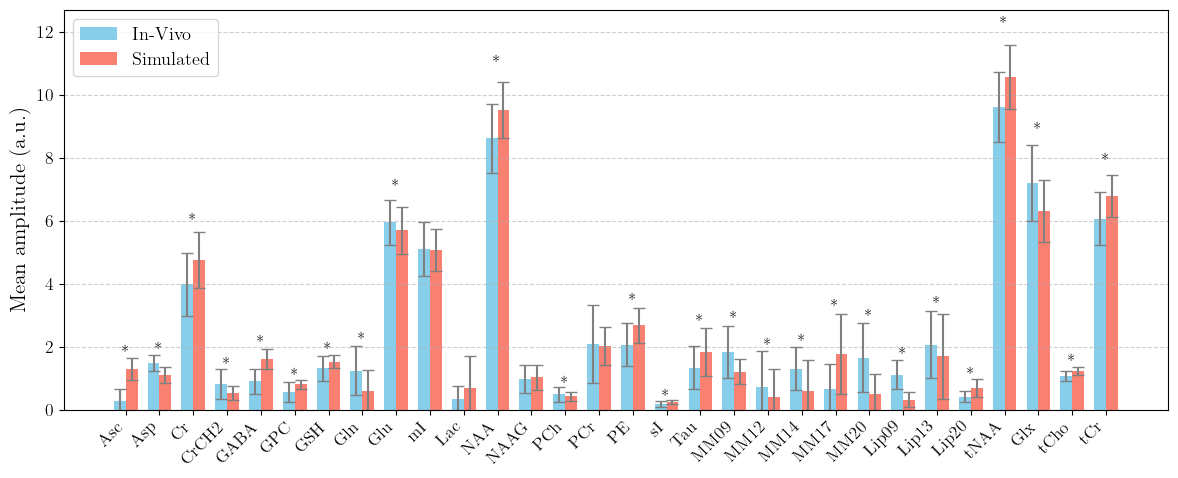


Summary DataFrame:
       invivo_mean  invivo_std  invivo_median  sim_mean  sim_std  sim_median  \
Asc          0.289       0.384          0.127     1.306    0.345       1.317   
Asp          1.483       0.256          1.472     1.112    0.244       1.087   
Cr           3.988       0.999          3.878     4.766    0.898       4.691   
CrCH2        0.829       0.476          0.762     0.538    0.217       0.524   
GABA         0.909       0.398          0.938     1.621    0.328       1.583   
GPC          0.587       0.315          0.524     0.815    0.153       0.801   
GSH          1.332       0.396          1.235     1.540    0.218       1.523   
Gln          1.257       0.789          1.397     0.602    0.683       0.432   
Glu          5.958       0.707          5.933     5.708    0.736       5.681   
mI           5.118       0.864          4.904     5.085    0.676       5.042   
Lac          0.357       0.411          0.221     0.695    1.028       0.236   
NAA          8.627  

In [5]:
# === User-configurable settings ===
quant_mode = 'ampl'            # Quantification mode: 'ampl' for amplitude, 'tCr' for tCr-normalized values
include_simulated = True       # Include simulated data in analysis and plots

# === Map quantification modes to result files ===
quant_file_map = {
    'ampl': 'A_amplMets_Voxel_1_Basis_1.tsv',
    'tCr': 'A_tCr_Voxel_1_Basis_1.tsv'
}

# === Helper functions ===
def load_quant_data(base_path, quant_file):
    """Load quantification data from a TSV file."""
    full_path = os.path.join(base_path, 'derivatives', 'QuantifyResults', quant_file)
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"File not found: {full_path}")
    return pd.read_csv(full_path, sep='\t')

def compute_summary(df):
    """Compute mean, std, and median per metabolite."""
    return df.agg(['mean', 'std', 'median']).T.round(3)

def compute_statistical_differences(df_invivo, df_sim):
    """
    Perform Mann-Whitney U test per metabolite between in-vivo and simulated data.
    Returns a Series of p-values.
    """
    p_values = {}
    for metabolite in df_invivo.columns:
        if metabolite in df_sim.columns:
            group1 = df_invivo[metabolite].dropna()
            group2 = df_sim[metabolite].dropna()
            if len(group1) > 0 and len(group2) > 0:
                _, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
                p_values[metabolite] = p_val
            else:
                p_values[metabolite] = None
    return pd.Series(p_values, name='p_value')

# === Load quantification data ===
quant_file = quant_file_map.get(quant_mode)
if quant_file is None:
    raise ValueError(f"Invalid quant_mode '{quant_mode}'. Choose from: {list(quant_file_map.keys())}")

df_invivo = load_quant_data(invivo_data_path, quant_file)
summary_invivo = compute_summary(df_invivo).add_prefix('invivo_')

if include_simulated:
    try:
        df_sim = load_quant_data(simulated_data_path, quant_file)
        summary_sim = compute_summary(df_sim).add_prefix('sim_')
        summary_combined = pd.concat([summary_invivo, summary_sim], axis=1)
        p_values = compute_statistical_differences(df_invivo, df_sim)
        summary_combined = summary_combined.join(p_values)
    except FileNotFoundError as e:
        print(f"Warning: {e}")
        print("Proceeding with in-vivo data only.")
        include_simulated = False
        summary_combined = summary_invivo
else:
    summary_combined = summary_invivo

# === Plotting function ===
def plot_grouped_bar_with_error(summary_df, metric='mean', include_simulated=True, pval_column='p_value'):
    import numpy as np
    import matplotlib.pyplot as plt

    metabolites = summary_df.index.tolist()
    x = np.arange(len(metabolites))
    width = 0.35

    invivo_vals = summary_df[f'invivo_{metric}'].values
    invivo_err = summary_df.get('invivo_std', pd.Series(0, index=summary_df.index)).values

    fig, ax = plt.subplots(figsize=(12, 5))
    bars1 = ax.bar(x - (width/2 if include_simulated else 0), invivo_vals, width,
                   yerr=invivo_err, capsize=4, label='In-Vivo', color='skyblue', ecolor='gray')

    if include_simulated and f'sim_{metric}' in summary_df.columns:
        sim_vals = summary_df[f'sim_{metric}'].values
        sim_err = summary_df.get('sim_std', pd.Series(0, index=summary_df.index)).values
        bars2 = ax.bar(x + width/2, sim_vals, width,
                       yerr=sim_err, capsize=4, label='Simulated', color='salmon', ecolor='gray')

        # Annotate significance based on p-values
        if pval_column in summary_df.columns:
            for i, metabolite in enumerate(metabolites):
                p = summary_df.loc[metabolite, pval_column]
                if pd.notnull(p) and p < 0.05:
                    y_max = max(invivo_vals[i] + invivo_err[i], sim_vals[i] + sim_err[i])
                    ax.text(x[i], y_max + 0.05 * y_max, '*', ha='center', va='bottom', color='black', fontsize=12)

    ax.set_ylabel('Mean amplitude (a.u.)' if metric == 'mean' else metric.capitalize())
    ax.set_xticks(x)
    ax.set_xticklabels(metabolites, rotation=45, ha='right')
    ax.set_ylim(0, max(invivo_vals.max(), sim_vals.max() if include_simulated else 0) * 1.2)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# === Create the plot ===
plot_grouped_bar_with_error(summary_combined, metric='mean', include_simulated=include_simulated)

print("\nSummary DataFrame:")
print(summary_combined)


## Quality Metric (QM) Data Loading and Summary

This section loads quality metric (QM) data from tab-separated files for both in-vivo and simulated datasets (if included).  
It then displays descriptive statistics (mean, std, quartiles) to provide an overview of the QM data distributions.

In [6]:
def load_qm_data(base_path):
    """
    Load quality metric (QM) data from a TSV file within the specified base path.

    Args:
        base_path (str): Root directory path.

    Returns:
        pd.DataFrame: QM data table.
    """
    full_path = os.path.join(base_path, 'derivatives', 'QM_processed_spectra.tsv')
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"File not found: {full_path}")
    return pd.read_csv(full_path, sep='\t')


# === Load QM data for in-vivo and simulated datasets ===
qm_invivo = load_qm_data(invivo_data_path)
qm_simulated = load_qm_data(simulated_data_path) if include_simulated else None

# === Print descriptive summary statistics ===
print("\nIn-Vivo QM Data Summary:")
print(qm_invivo.describe().round(3))

if include_simulated and qm_simulated is not None:
    print("\nSimulated QM Data Summary:")
    print(qm_simulated.describe().round(3))



In-Vivo QM Data Summary:
        Cr_SNR  Cr_FWHM  water_FWHM  residual_water_ampl  freqShift  relResA
count  104.000  104.000     104.000              104.000    104.000  104.000
mean   143.415    6.335       6.881                0.259     -3.008   13.243
std     38.561    1.212       0.638                0.411      1.468   12.327
min     73.357    4.713       5.608                0.008     -7.660    3.095
25%    115.126    5.543       6.434                0.017     -3.449    7.334
50%    144.265    6.040       6.787                0.148     -3.272   11.049
75%    173.268    6.795       7.202                0.347     -2.440   15.444
max    257.809   11.824       8.650                2.801      6.202  106.021

Simulated QM Data Summary:
        Cr_SNR  Cr_FWHM  residual_water_ampl  freqShift  relResA
count  480.000  480.000              480.000    480.000  480.000
mean   106.647    6.322             1449.905     -0.078    5.842
std     11.432    0.630              873.399      0.543   

## Loading and Processing Spectra

In [7]:
# === 1. Load spectra from folders ===
sim_spectra_dict = list_spectra_in_folder(simulated_data_path, possible_components=['total'])
invivo_file_pairs = list_invivo_spectra_in_folder(invivo_data_path)

# === 2. Preprocess in-vivo spectra ===
invivo_spectra_raw = []
for pair in tqdm(invivo_file_pairs, desc="Processing In-vivo Spectra"):
    mrs = preprocess_press(pair)                    # Preprocessing routine for PRESS acquisition
    ppm_axis = mrs.getAxes('ppmshift')              # Chemical shift axis (ppm), assumed consistent
    norm_spec = mrs.get_spec() / np.max(np.abs(mrs.get_spec()))  # Normalize spectrum amplitude
    invivo_spectra_raw.append(norm_spec)
invivo_spectra_raw = np.array(invivo_spectra_raw)

# === 3. Preprocess simulated spectra ===
sim_spectra_raw = []
sim_spectrum_ids = []
for sim_id, components in tqdm(sim_spectra_dict.items(), desc="Processing Simulated Spectra"):
    for path in components['components'].values():
        mrs = preprocess_press_sim(path)              # Preprocessing for simulated data
        ppm_axis = mrs.getAxes('ppmshift')            # Chemical shift axis (ppm)
        norm_spec = mrs.get_spec() / np.max(np.abs(mrs.get_spec()))  # Normalize
        sim_spectra_raw.append(norm_spec)
        sim_spectrum_ids.append(sim_id)
sim_spectra_raw = np.array(sim_spectra_raw)


Processing Simulated Spectra: 100%|██████████| 480/480 [08:33<00:00,  1.07s/it]


In [8]:
# === 4. Baseline Correction and Normalization ===
baseline_indices = find_ppm_indices(ppm_axis, *baseline_ppm_range)

invivo_spectra_bc = baseline_correct(invivo_spectra_raw, baseline_indices)
sim_spectra_bc = baseline_correct(sim_spectra_raw, baseline_indices)

invivo_spectra_norm = normalize_spectra(invivo_spectra_bc)
sim_spectra_norm = normalize_spectra(sim_spectra_bc)

## Prepare for t-SNE analysis and plotting

In [9]:
# === 5. Feature Extraction (Real+Imag, selected ppm range) ===
pca_indices = find_ppm_indices(ppm_axis, *pca_ppm_range)

invivo_features = concat_real_imag_and_select_range(invivo_spectra_norm, pca_indices)
sim_features = concat_real_imag_and_select_range(sim_spectra_norm, pca_indices)

# === 6. Combine Spectra for Analysis ===
all_features = np.vstack([invivo_features, sim_features])
all_features_real = all_features[:, :all_features.shape[1] // 2]  # Optional: use only real part

group_labels = np.array(['In-vivo'] * len(invivo_features) + ['Simulated'] * len(sim_features))
spectrum_labels = np.array(
    [f"In-vivo_{i}" for i in range(len(invivo_features))] + sim_spectrum_ids
)

## Apply PCA + t-SNE

In [10]:
# === 7. PCA + t-SNE ===
scaler = StandardScaler()
scaled_features = scaler.fit_transform(all_features_real)

pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(scaled_features)

perplexities = [5, 10, 20, 30, 40, 50]
tsne_results = {}
for perplexity in tqdm(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, init='random', random_state=42, max_iter=1000)
    tsne_coords = tsne.fit_transform(pca_features)
    tsne_results[perplexity] = tsne_coords


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


## Plot of averages

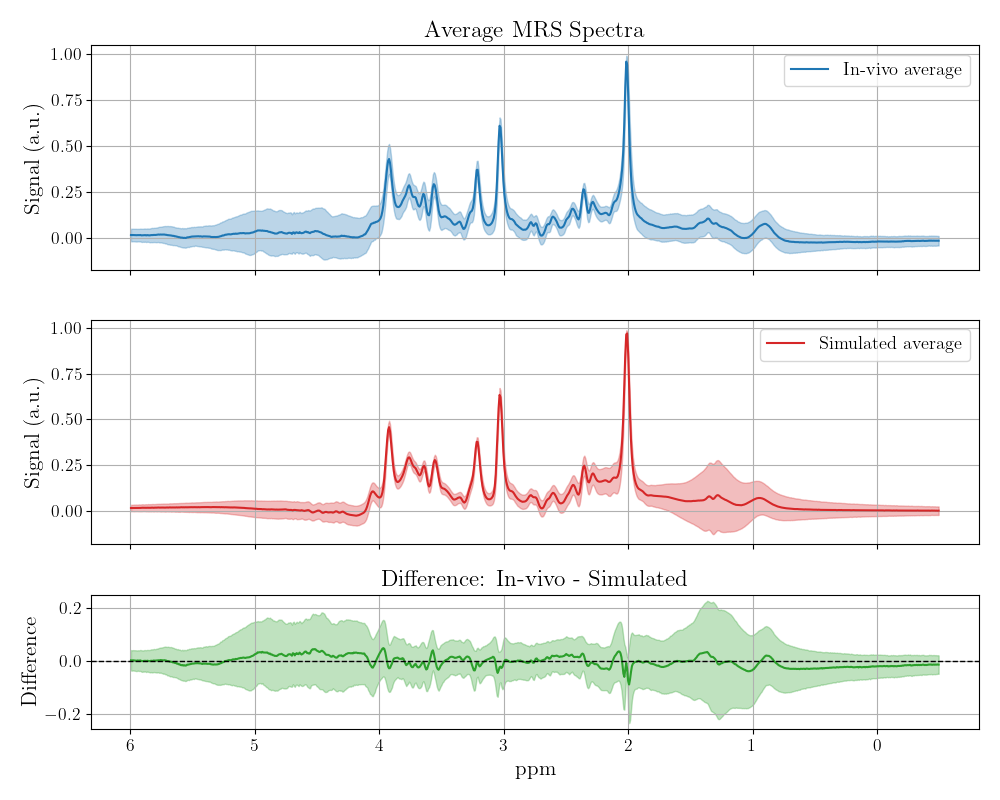

In [11]:
# === 9. Static Spectra Plot ===
%matplotlib widget

plot_avg_spectra_with_std_and_diff(invivo_spectra_norm, sim_spectra_norm, ppm_axis, pca_ppm_range)

## Interactive t-SNE Visualization of Spectra

This block creates an interactive t-SNE scatter plot to visualize and compare in-vivo and simulated MRS spectra in reduced-dimensional space. Key features include:

- Points colored by data source (In-vivo or Simulated).
- Clickable scatter plot to select up to 10 spectra to display detailed spectral plots.
- Toggle to show/hide imaginary parts of spectra.
- Controls to clear selections and adjust t-SNE perplexity parameter dynamically.
- Legends and axis labels for clarity.


/var/folders/yw/ljc13tcx0g505pnn9bjzq3yr0000gn/T/ipykernel_64913/3663590173.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_spec.legend()


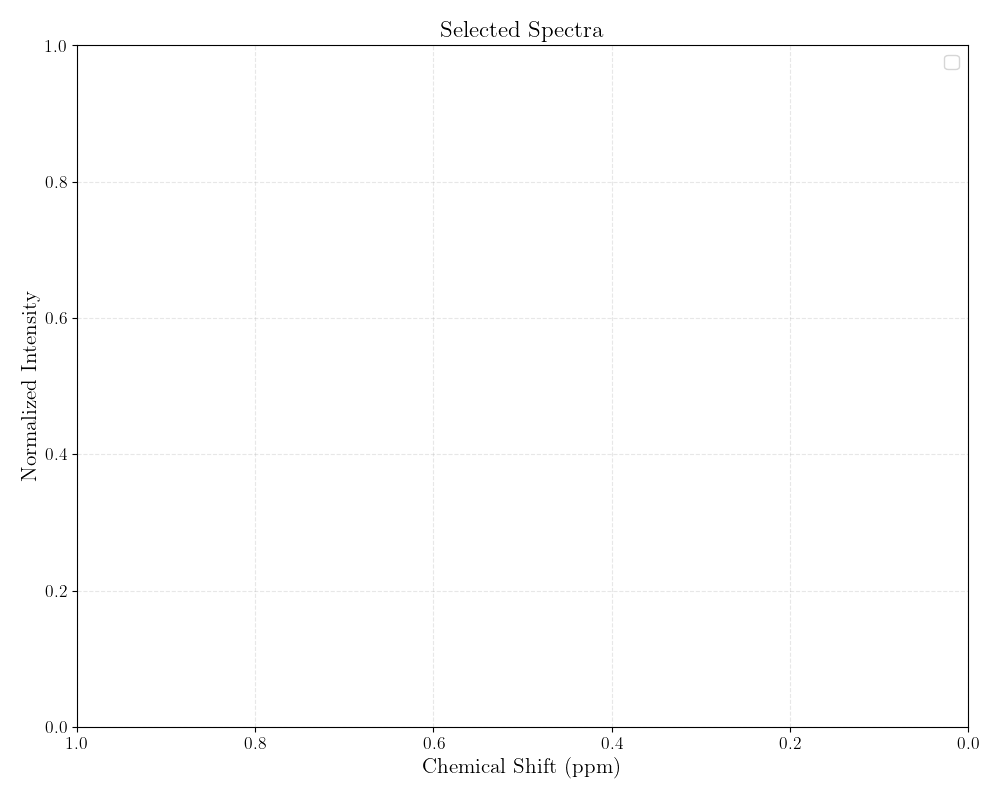

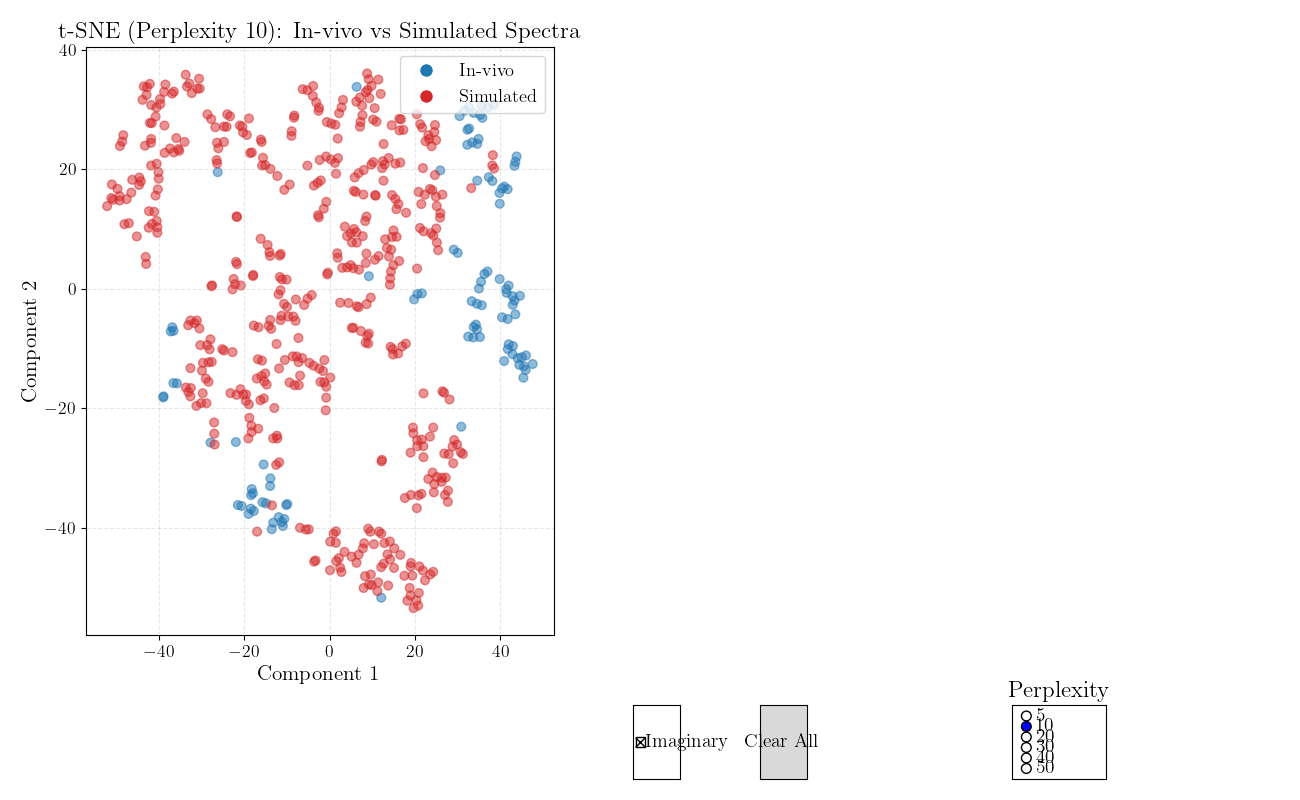

In [14]:
%matplotlib widget

# Simplified color scheme
selection_colors = {
    'In-vivo': '#1f77b4',          # deep blue
    'Simulated': '#d62728',        # crimson red
    'highlight_inviv': '#aec7e8',  # light blue for highlight
    'highlight_sim': '#ff9896',    # light red for highlight
}

# === Setup figure ===
fig = plt.figure(figsize=(13, 8))
gs = GridSpec(2, 6, height_ratios=[8, 1], width_ratios=[5, 0.5, 0.5, 0.5, 1, 1])
ax_tsne = fig.add_subplot(gs[0, 0])

# === Initial t-SNE data ===
current_perplexity = perplexities[1]
tsne_coords = tsne_results[current_perplexity]

# === t-SNE Scatter ===
color_map = {key: selection_colors[key] for key in ['In-vivo', 'Simulated']}

point_colors = [color_map.get(label, '#cccccc') for label in group_labels]

sc = ax_tsne.scatter(tsne_coords[:, 0], tsne_coords[:, 1],
                     c=point_colors, alpha=0.5, s=40)
ax_tsne.set_title(f't-SNE (Perplexity {current_perplexity}): In-vivo vs Simulated Spectra')
ax_tsne.set_xlabel('Component 1')
ax_tsne.set_ylabel('Component 2')
ax_tsne.grid(True, linestyle='--', alpha=0.3)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='In-vivo', markerfacecolor=selection_colors['In-vivo'], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Simulated', markerfacecolor=selection_colors['Simulated'], markersize=10),
]
ax_tsne.legend(handles=legend_elements, loc='upper right')

# Highlight marker, initially empty
highlight_marker = ax_tsne.scatter([], [], facecolors='none', edgecolors='black', s=120, linewidths=2)

# === Spectrum plot ===
fig_spec, ax_spec = plt.subplots(figsize=(10, 8))
selected_spectra = []
imaginary_visible = [True]

def update_spectrum_plot():
    ax_spec.clear()

    # Separate selected indices by class
    invivo_indices = [idx for idx in selected_spectra if group_labels[idx] == 'In-vivo']
    sim_indices = [idx for idx in selected_spectra if group_labels[idx] == 'Simulated']

    # Generate color gradients for each class
    invivo_cmap = cm.Blues
    sim_cmap = cm.Reds

    # Create line colors spaced evenly in the colormap (avoid extremes)
    invivo_colors = [invivo_cmap(0.3 + 0.7 * i / max(1, len(invivo_indices)-1)) for i in range(len(invivo_indices))]
    sim_colors = [sim_cmap(0.3 + 0.7 * i / max(1, len(sim_indices)-1)) for i in range(len(sim_indices))]

    # Plot In-vivo spectra
    for i, idx in enumerate(invivo_indices):
        spectrum = all_features[idx]
        mid = len(spectrum) // 2
        real = spectrum[:mid]
        imag = spectrum[mid:]
        ppm = ppm_axis[pca_indices]

        ax_spec.plot(ppm, real, label=spectrum_labels[idx], color=invivo_colors[i])
        if imaginary_visible[0]:
            ax_spec.plot(ppm, imag, '--', color=invivo_colors[i], alpha=0.6)

    # Plot Simulated spectra
    for i, idx in enumerate(sim_indices):
        spectrum = all_features[idx]
        mid = len(spectrum) // 2
        real = spectrum[:mid]
        imag = spectrum[mid:]
        ppm = ppm_axis[pca_indices]

        ax_spec.plot(ppm, real, label=spectrum_labels[idx], color=sim_colors[i])
        if imaginary_visible[0]:
            ax_spec.plot(ppm, imag, '--', color=sim_colors[i], alpha=0.6)

    ax_spec.set_title("Selected Spectra")
    ax_spec.set_xlabel("Chemical Shift (ppm)")
    ax_spec.set_ylabel("Normalized Intensity")
    ax_spec.legend()
    ax_spec.grid(True, linestyle='--', alpha=0.3)
    ax_spec.invert_xaxis()
    fig_spec.tight_layout()
    fig_spec.canvas.draw()

    # Update highlight markers (keep as before)
    if selected_spectra:
        coords = tsne_coords[selected_spectra]
        highlight_colors = []
        for idx in selected_spectra:
            label = group_labels[idx]
            if label == 'In-vivo':
                highlight_colors.append(selection_colors['highlight_inviv'])
            else:
                highlight_colors.append(selection_colors['highlight_sim'])
        highlight_marker.set_offsets(coords)
        highlight_marker.set_facecolors(highlight_colors)
        highlight_marker.set_edgecolors('black')
    else:
        highlight_marker.set_offsets(np.empty((0, 2)))
        highlight_marker.set_facecolors([])
        highlight_marker.set_edgecolors([])


def toggle_imaginary(label):
    imaginary_visible[0] = not imaginary_visible[0]
    update_spectrum_plot()

def clear_selection(event):
    selected_spectra.clear()
    update_spectrum_plot()

def on_tsne_click(event):
    if event.inaxes != ax_tsne:
        return
    dist = np.linalg.norm(tsne_coords - [event.xdata, event.ydata], axis=1)
    idx = np.argmin(dist)
    if idx in selected_spectra:
        selected_spectra.remove(idx)
    elif len(selected_spectra) < 10:
        selected_spectra.append(idx)
    else:
        print("Maximum of 10 spectra.")
    update_spectrum_plot()

def update_tsne_plot(label):
    global tsne_coords, current_perplexity
    current_perplexity = int(label)
    tsne_coords = tsne_results[current_perplexity]

    sc.set_offsets(tsne_coords)
    ax_tsne.set_title(f't-SNE (Perplexity {current_perplexity}): In-vivo vs Simulated Spectra')

    # Axis padding
    padding = 5  # percent
    x_min, x_max = tsne_coords[:, 0].min(), tsne_coords[:, 0].max()
    y_min, y_max = tsne_coords[:, 1].min(), tsne_coords[:, 1].max()
    x_pad = (x_max - x_min) * padding / 100
    y_pad = (y_max - y_min) * padding / 100

    ax_tsne.set_xlim(x_min - x_pad, x_max + x_pad)
    ax_tsne.set_ylim(y_min - y_pad, y_max + y_pad)

    update_spectrum_plot()
    fig.canvas.draw_idle()

# === Controls below ===
check_ax = fig.add_subplot(gs[1, 1])
imaginary_checkbox = CheckButtons(check_ax, ['Imaginary'], [True])
imaginary_checkbox.on_clicked(toggle_imaginary)

clear_ax = fig.add_subplot(gs[1, 2])
clear_btn = Button(clear_ax, 'Clear All')
clear_btn.on_clicked(clear_selection)

radio_ax = fig.add_subplot(gs[1, 4])
radio = RadioButtons(radio_ax, [str(p) for p in perplexities])
radio.on_clicked(update_tsne_plot)
radio.set_active(1)  # Set initial active perplexity
radio_ax.set_title("Perplexity")

fig.canvas.mpl_connect('button_press_event', on_tsne_click)
fig.tight_layout()
plt.show()


## Saving

Similar code as above, but creates a static image and saves it.

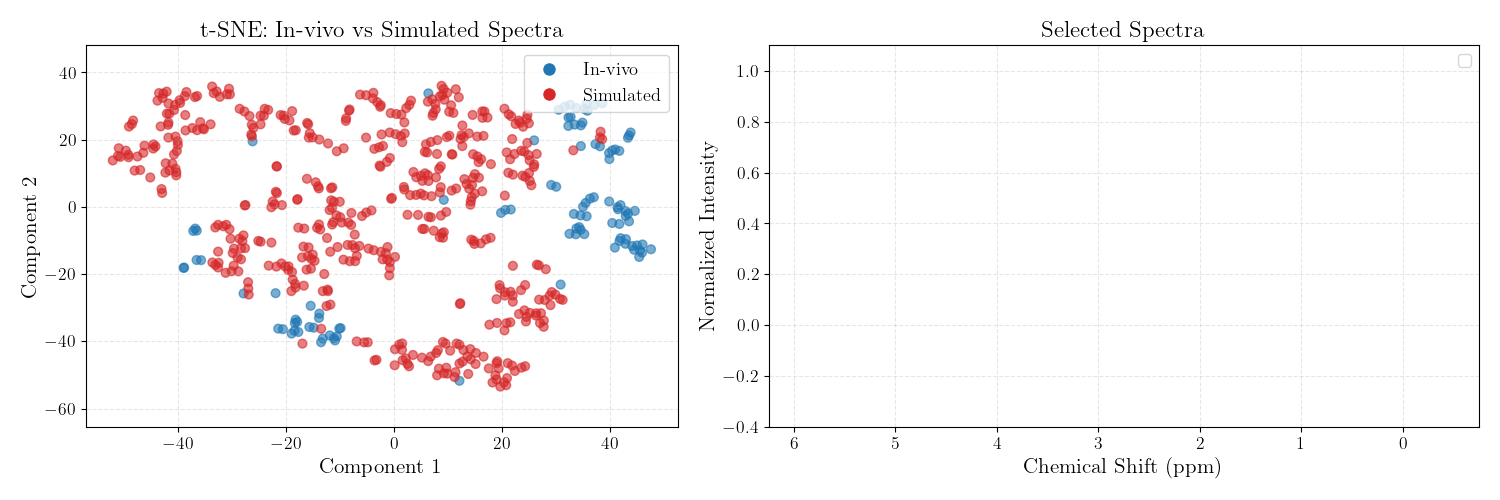

In [ ]:
# Simplified color scheme
selection_colors = {
    'In-vivo': '#1f77b4',          # deep blue
    'Simulated': '#d62728',        # crimson red
    'highlight_inviv': '#aec7e8',  # light blue for highlight
    'highlight_sim': '#ff9896',    # light red for highlight
}

# === User input: indices to plot spectra for ===
# Use the selected spectra indices from interactive session
selected_spectra_static = list(selected_spectra)  # copy current selection
# Use the current perplexity from interactive
current_perplexity_static = current_perplexity  # e.g., 30
tsne_coords = tsne_results[current_perplexity_static]

# Prepare figure with 2 panels side by side
fig, (ax_tsne, ax_spec) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1.2]})

# --- t-SNE plot ---
# Point colors by class
point_colors = [selection_colors.get(label, '#cccccc') for label in group_labels]
ax_tsne.scatter(tsne_coords[:, 0], tsne_coords[:, 1],
                c=point_colors, alpha=0.6, s=40)

ax_tsne.set_title('t-SNE: In-vivo vs Simulated Spectra')
ax_tsne.set_xlabel('Component 1')
ax_tsne.set_ylabel('Component 2')
ax_tsne.grid(True, linestyle='--', alpha=0.3)

# Legend with only classes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='In-vivo', markerfacecolor=selection_colors['In-vivo'], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Simulated', markerfacecolor=selection_colors['Simulated'], markersize=10),
]
ax_tsne.legend(handles=legend_elements, loc='upper right')

# Highlight selected points with black edge and larger size
selected_coords = tsne_coords[selected_spectra_static]
selected_labels = [group_labels[i] for i in selected_spectra_static]
highlight_colors = []
for label in selected_labels:
    if label == 'In-vivo':
        highlight_colors.append(selection_colors['highlight_inviv'])
    else:
        highlight_colors.append(selection_colors['highlight_sim'])

ax_tsne.scatter(
    selected_coords[:, 0],
    selected_coords[:, 1],
    facecolors=highlight_colors,
    edgecolors='black',      # black border
    s=200,                   # larger size (tune as needed)
    linewidths=2,
    marker='o',
    label='Selected',
    zorder=5
)

ax_tsne.set_ylim(tsne_coords[:, 1].min() - 12, tsne_coords[:, 1].max() + 12)

# --- Spectrum plot ---
# Separate selected indices by class
invivo_indices = [idx for idx in selected_spectra_static if group_labels[idx] == 'In-vivo']
sim_indices = [idx for idx in selected_spectra_static if group_labels[idx] == 'Simulated']

# Colormaps for gradient colors within class
invivo_cmap = cm.Blues
sim_cmap = cm.Reds

invivo_colors = [invivo_cmap(0.3 + 0.7 * i / max(1, len(invivo_indices)-1)) for i in range(len(invivo_indices))]
sim_colors = [sim_cmap(0.3 + 0.7 * i / max(1, len(sim_indices)-1)) for i in range(len(sim_indices))]

ppm = ppm_axis[pca_indices]

# Plot In-vivo spectra
for i, idx in enumerate(invivo_indices):
    spectrum = all_features[idx]
    mid = len(spectrum) // 2
    real = spectrum[:mid]
    ax_spec.plot(ppm, real, color=invivo_colors[i])

# Plot Simulated spectra
for i, idx in enumerate(sim_indices):
    spectrum = all_features[idx]
    mid = len(spectrum) // 2
    real = spectrum[:mid]
    ax_spec.plot(ppm, real, color=sim_colors[i])

ax_spec.set_title("Selected Spectra")
ax_spec.set_xlabel("Chemical Shift (ppm)")
ax_spec.set_ylabel("Normalized Intensity")
ax_spec.set_ylim(-0.4, 1.1)
ax_spec.set_xlim(-0.75, 6.25)  # Adjust y-l
ax_spec.grid(True, linestyle='--', alpha=0.3)
ax_spec.invert_xaxis()

# Prepare legend handles for individual spectra
legend_handles = []

# In-vivo spectra legend
for i, color in enumerate(invivo_colors):
    label = f'In-vivo {i+1}'
    legend_handles.append(plt.Line2D([0], [0], color=color, label=label))

# Simulated spectra legend
for i, color in enumerate(sim_colors):
    label = f'Simulated {i+1}'
    legend_handles.append(plt.Line2D([0], [0], color=color, label=label))

# Show legend with all selected spectra labeled individually
ax_spec.legend(handles=legend_handles, loc='upper right', fontsize='small', ncol=1)

plt.tight_layout()
plt.show()

# plt.savefig('tsne_spectra_selection.png', dpi=300, bbox_inches='tight')
